## Advanced Lane Finding Project

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from skimage import io
import sklearn as sk
from util import Camera

%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.fit = None
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

## Camera calibration using chessboard images

In [3]:
camera = Camera()

## Image undistortion example

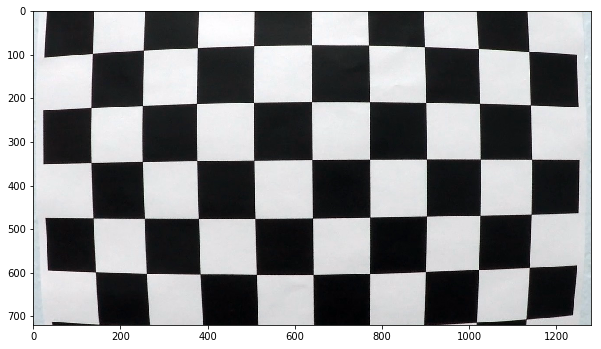

In [4]:
chessboard = cv2.imread('../camera_cal/calibration1.jpg')
chessboard_undist = camera.undistort(chessboard)

plt.imshow(chessboard)

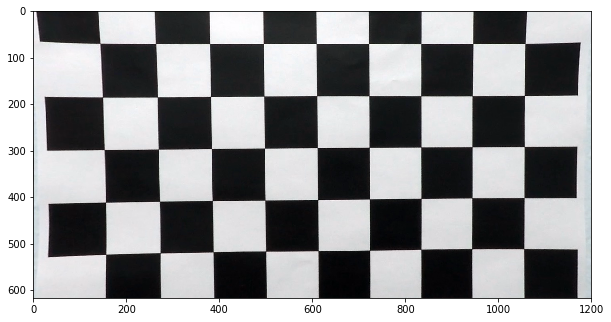

In [5]:
plt.imshow(chessboard_undist)

## Warp perspective

In [67]:
lane = io.imread('../test_images/straight_lines1.jpg')
lane_undist = camera.undistort(lane, True)

lane_curved = io.imread('../test_images/test6.jpg')
lane_curved_undist = camera.undistort(lane_curved)

## Warp perspective: source

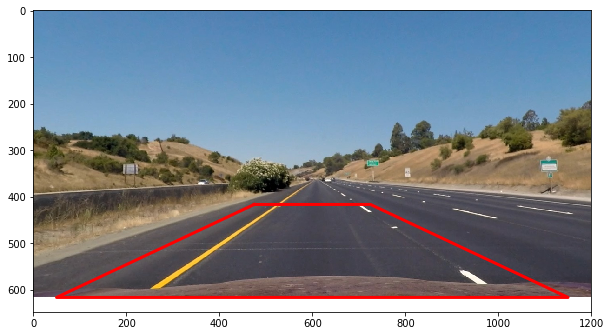

In [68]:
from util import Perspective 

perspective = Perspective(chessboard_undist.shape[0], chessboard_undist.shape[1])
pf = perspective.polygon_frame()

plt.imshow(lane_undist)
plt.plot(pf[:, 0], pf[:, 1], 'r', lw=3)

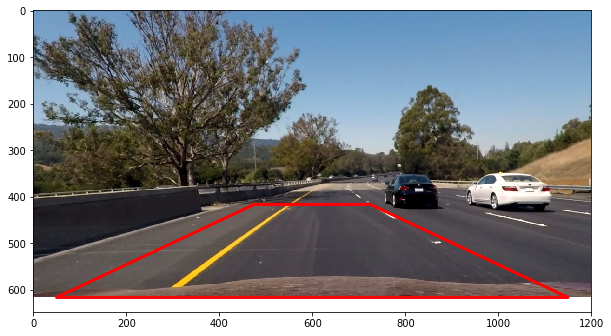

In [69]:
plt.imshow(lane_curved_undist)
plt.plot(pf[:, 0], pf[:, 1], 'r', lw=3)

## Warp perspective: destination

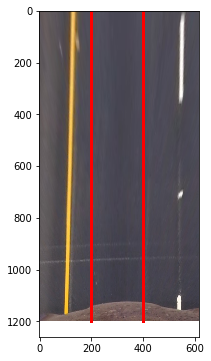

In [70]:
# for xx in range(0, lane_undist.shape[1], 100):
#     for yy in range(0, lane_undist.shape[0]):
#         lane_undist[yy, xx] = [0, 255, 0]

lane_warped = perspective.warp(lane_undist)
        
lane_warped_curved = perspective.warp(lane_undist)

plt.imshow(lane_warped)

plot((200, 200), (0, lane_warped.shape[0]), 'r', lw=3)
plot((400, 400), (0, lane_warped.shape[0]), 'r', lw=3)

## Threshold binary image

In [44]:
hood_mask = cv2.cvtColor(cv2.imread('hood_mask.png'), cv2.COLOR_BGR2GRAY)
hood_mask_undist = camera.undistort(hood_mask)
hood_mask_warped = perspective.warp(hood_mask_undist)

In [45]:
from util import FeatureExtractor

extractor = FeatureExtractor()

def frame_feature_extract(image):
    undist = camera.undistort(image)
    warped = perspective.warp(undist)
    binary = extractor.pipeline(warped)

    return cv2.bitwise_and(binary, binary, mask=hood_mask_warped)

lane_binary = frame_feature_extract(lane)
lane_curved_binary = frame_feature_extract(lane_curved)

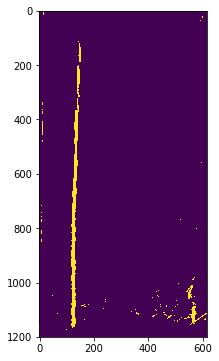

In [75]:
test1 = io.imread('../test_images/test1.jpg')

plt.imshow(frame_feature_extract(test1))

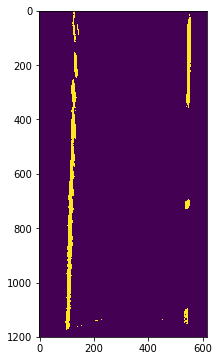

In [76]:
plt.imshow(frame_feature_extract(lane))

/Users/yuri/work/udacity/cv/CarND-Advanced-Lane-Lines/advanced_lane_detection_final_new/util.py:228: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.sum(self.image[self.image.shape[0]/2:,:], axis=0)


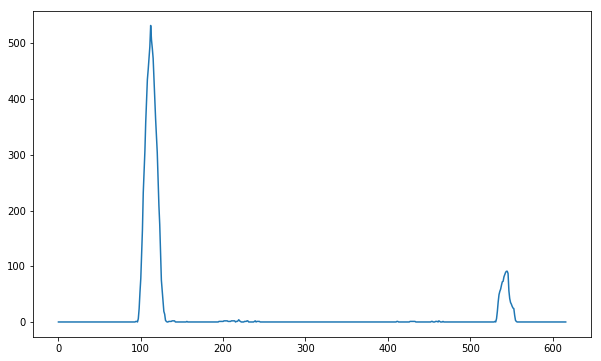

In [48]:
from util import LaneFinder

lane_finder = LaneFinder(lane_binary)

plt.plot(lane_finder.histogram)

## Fit with polynomial

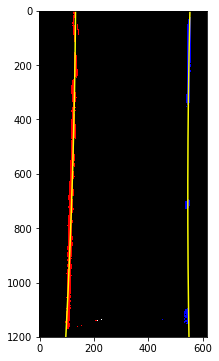

In [49]:
def fit_polinomial(fit, x):
    return fit[0] * x ** 2 + fit[1] * x + fit[2]

def plot_fit(pp, lane_finder):
    out_img = np.uint8(np.dstack((lane_finder.image, lane_finder.image, lane_finder.image))*255)
    ploty = np.linspace(0, lane_finder.image.shape[0] - 1, lane_finder.image.shape[0])
    
    left_fitx = fit_polinomial(lane_finder.fits[0], ploty)
    right_fitx = fit_polinomial(lane_finder.fits[1], ploty)

    leftx, lefty, rightx, righty = lane_finder.extract_pixels()
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    pp.imshow(out_img)
    pp.plot(left_fitx, ploty, color='yellow')
    pp.plot(right_fitx, ploty, color='yellow')

plot_fit(plt, lane_finder)

In [50]:
# def margin_inds(binary_warped, left_fit, right_fit, margin):
#     # Assume you now have a new warped binary image 
#     # from the next frame of video (also called "binary_warped")
#     # It's now much easier to find line pixels!
#     nonzeroy, nonzerox = nonzero(binary_warped)
    
#     left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
#     right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
#     return left_lane_inds, right_lane_inds

# def local_refit(binary_warped, left_fit, right_fit, margin):
#     left_lane_inds, right_lane_inds = margin_inds(binary_warped, left_fit, right_fit, margin)
#     left_fit, right_fit = fit_lanes(binary_warped, left_lane_inds, right_lane_inds)
    
#     return left_lane_inds, right_lane_inds, left_fit, right_fit

# def extract_pixels_fit_margin_search(binary_warped, left_fit, right_fit, margin):
#     left_lane_inds, right_lane_inds = margin_inds(binary_warped, left_fit, right_fit, margin)
    
#     return extract_pixels(binary_warped, left_lane_inds, right_lane_inds)   
    
# def plot_margin_search(binary_warped, left_fit, right_fit, margin = 100):   
#     nonzeroy, nonzerox = nonzero(binary_warped)
    
#     leftx, lefty, rightx, righty = extract_pixels_fit_margin_search(binary_warped, left_fit, right_fit, margin)
    
#     # Generate x and y values for plotting
#     ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#     # Create an image to draw on and an image to show the selection window
#     #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
#     out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)
#     window_img = np.zeros_like(out_img)
    
#     # Color in left and right line pixels
#     out_img[lefty, leftx] = [255, 0, 0]
#     out_img[righty, rightx] = [0, 0, 255]

#     # Generate a polygon to illustrate the search window area
#     # And recast the x and y points into usable format for cv2.fillPoly()
#     left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
#     left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
#     left_line_pts = np.hstack((left_line_window1, left_line_window2))
#     right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
#     right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
#     right_line_pts = np.hstack((right_line_window1, right_line_window2))

#     # Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
#     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
#     plt.imshow(result)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')

# plot_margin_search(lane_binary, lane_finder.fits[0], lane_finder.fits[1])

In [51]:
# print(left_fit)
# print(right_fit)

## Calculate curvead

In [52]:
print(lane_finder.curveads[0], 'm', lane_finder.curveads[1], 'm')

26438.7480234 m 30116.0419298 m


## Result layered image

In [73]:
left_lane = Line()
right_lane = Line()

def sanity_check(lane, fit, yvals, curvature):
    if lane.fit is None:
        lane.radius_of_curvature = curvature
        lane.fit = fit
        lane.detected = True
        lane.count_skip = 0
    else:
        a = np.column_stack((lane.fit[0] * yvals ** 2 + lane.fit[1] * yvals + lane.fit[2], yvals))
        b = np.column_stack((fit[0] * yvals ** 2 + fit[1] * yvals + fit[2], yvals))
        ret = cv2.matchShapes(a, b, 1, 0.0)

        if (ret < 0.005) | (lane.count_skip > 20):
            lane.radius_of_curvature = curvature
            lane.fit = fit
            lane.detected = True
            lane.count_skip = 0
        else:
            lane.detected = False
            lane.count_skip += 1

    return lane.fit[0] * yvals ** 2 + lane.fit[1] * yvals + lane.fit[2]    

def layered_lane(image):
    undist = camera.undistort(image)
    warped = perspective.warp(undist)
    binary = extractor.pipeline(warped)

    binary = cv2.bitwise_and(binary, binary, mask=hood_mask_warped)

    lane_finder = LaneFinder(binary)
           
    out_img = np.uint8(np.dstack((binary, binary, binary))*255)
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0])

    left_fitx = sanity_check(left_lane, lane_finder.fits[0], ploty, lane_finder.curveads[0])
    right_fitx = sanity_check(right_lane, lane_finder.fits[1], ploty, lane_finder.curveads[1])
        
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))   
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = perspective.unwarp(color_warp, (undist.shape[1], undist.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result, left_lane.fit, right_lane.fit, left_lane.radius_of_curvature, right_lane.radius_of_curvature, lane_finder.curveads[2]

0.0891578018687


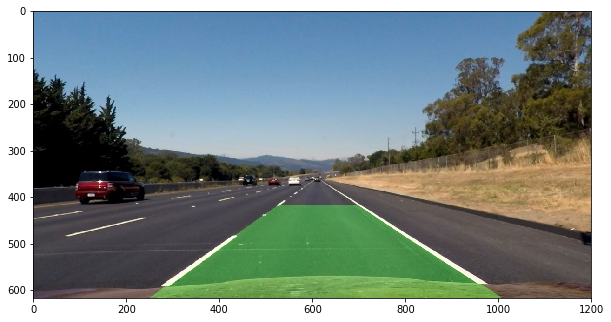

In [74]:
layered, left_fit, right_fit, left_curverad, right_curverad, curveads = layered_lane(io.imread('../test_images/straight_lines2.jpg'))
plt.imshow(layered)
print(curveads)

In [55]:
class FrameState():
    prev_left_fit = None
    prev_right_fit = None
    
    def anotate_frame(self, frame):
        layered, left_fit, right_fit, left_curverad, right_curverad, offset = layered_lane(frame)
        
        curverad = (left_curverad + right_curverad) / 2
        cv2.putText(layered, "Curvature: %s m" % str(round(curverad)) + " Offset: %s" % str(round(offset)),
                                                             (20, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 4, cv2.LINE_AA) 
        
        return layered
    
    def __call__(self, frame):
        return self.anotate_frame(frame)
    


In [56]:
from IPython.display import clear_output

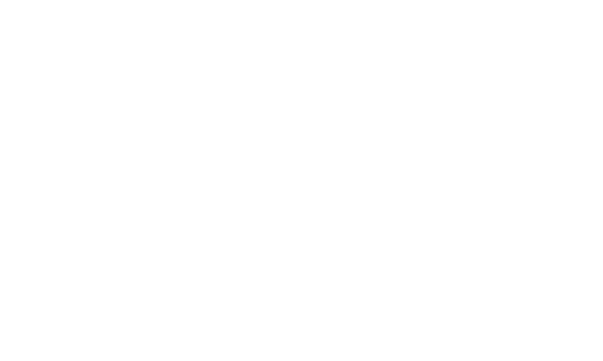

In [57]:
left_lane = Line()
right_lane = Line()

font = {'family': 'serif',
        'color':  'white',
        'weight': 'normal',
        'size': 16,
        }

vid = cv2.VideoCapture("../project_video.mp4")

prev_left_fit = prev_right_fit = None
try:
    while(True):
        ret, frame = vid.read()
        if not ret:
            vid.release()
            break
            
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        axis('off')

        layered, left_fit, right_fit, left_curverad, right_curverad, offset = layered_lane(frame)

        plt.imshow(layered)       
        plt.text(20, 34, 'L=' + str(round(left_curverad))
                 + 'm R=' + str(round(right_curverad))
                 + 'm Offset=' + str(round(offset, 2))
                 + 'm', fontdict=font)
        
        show()

        clear_output(wait=True)
        
except KeyboardInterrupt:
    # Release the Video Device
    vid.release()

In [59]:
from moviepy.editor import VideoFileClip

test_output = 'result.mp4'
clip = VideoFileClip('../project_video.mp4')
fl_clip = clip.fl_image(FrameState())
%time fl_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [07:36<00:00,  3.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 7min 39s, sys: 2min 7s, total: 9min 46s
Wall time: 7min 38s


## Problematic cases

In [155]:
problematic_files = glob.glob('problematic*.png')
problematics = []
for f in problematic_files:
    problematic_image = io.imread(f)
    problematic_undist = camera.undistort(problematic_image)
    problematic_warped = perspective.warp(problematic_undist)
    problematic_binary = extractor.pipeline(problematic_warped)
    problematic_binary = cv2.bitwise_and(problematic_binary, problematic_binary, mask=hood_mask_warped)
    problematic_lane_finder = LaneFinder(problematic_binary)

    problematics.append(dict(
        image=problematic_image,
        undist=problematic_undist,
        warped=problematic_warped,
        binary=problematic_binary,
        lane_finder=problematic_lane_finder
    ))
    
def plot_diagnostics(i):
    fig, ((a,b),(c,d)) = plt.subplots(2, 2, figsize=(18, 12))
    a.imshow(problematics[i]['image'])
    b.imshow(problematics[i]['warped'])
    c.imshow(problematics[i]['binary'])
    plot_fit(d, problematics[i]['lane_finder'])
    

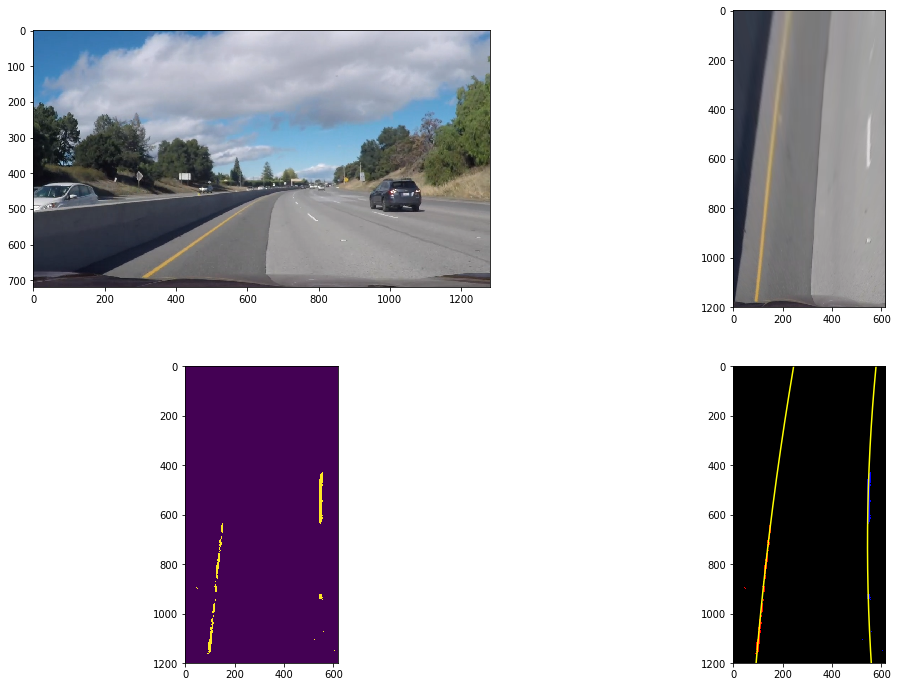

In [156]:
plot_diagnostics(0)

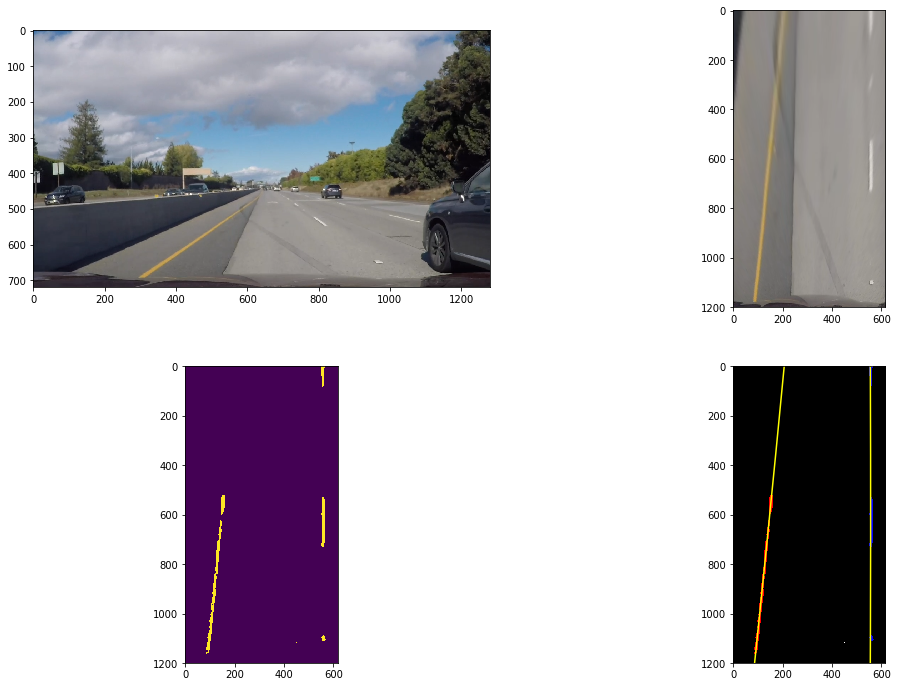

In [149]:
plot_diagnostics(1)

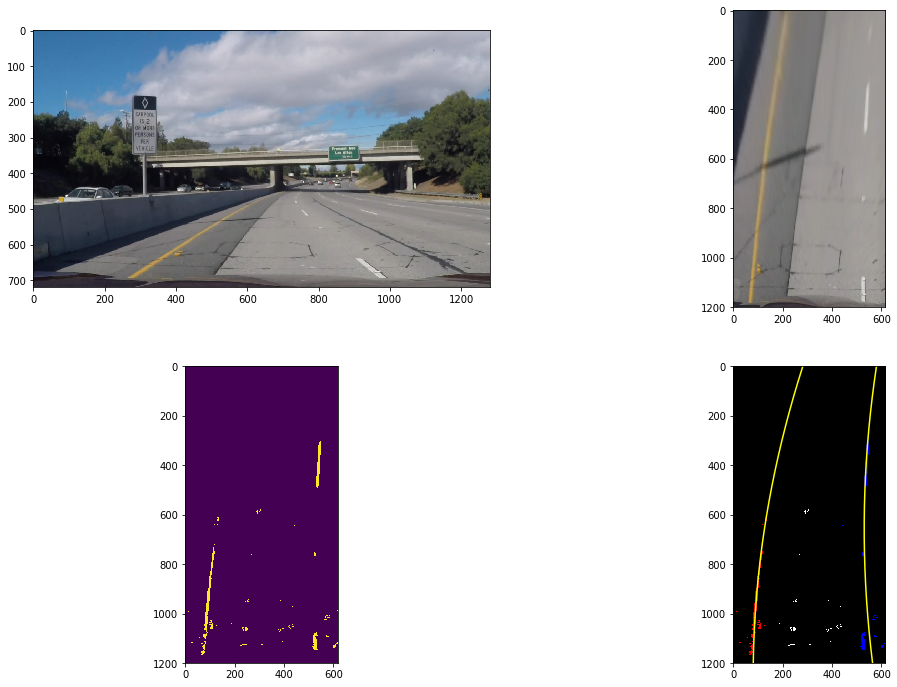

In [150]:
plot_diagnostics(2)

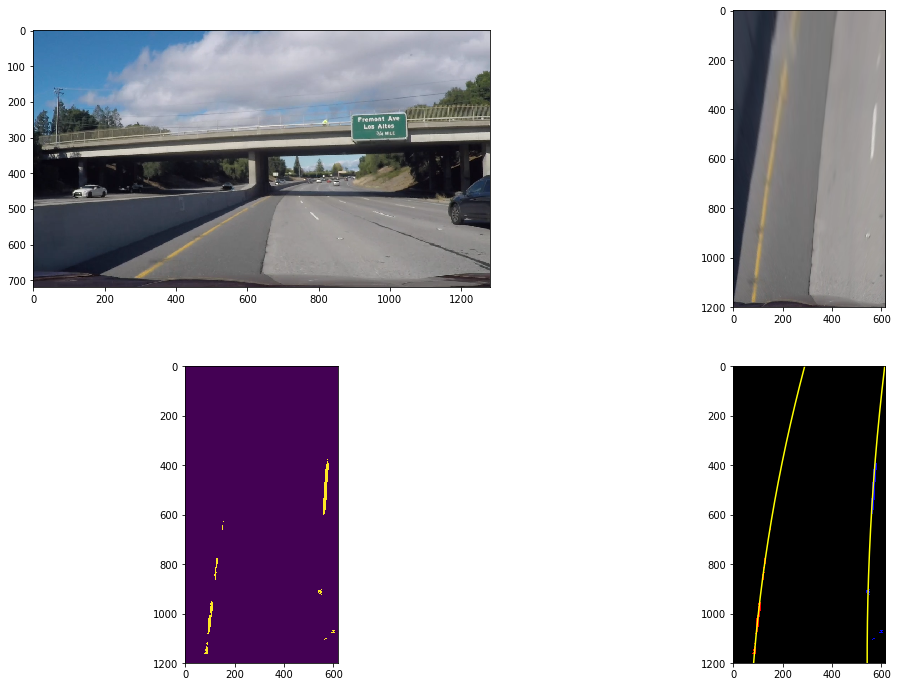

In [151]:
plot_diagnostics(3)

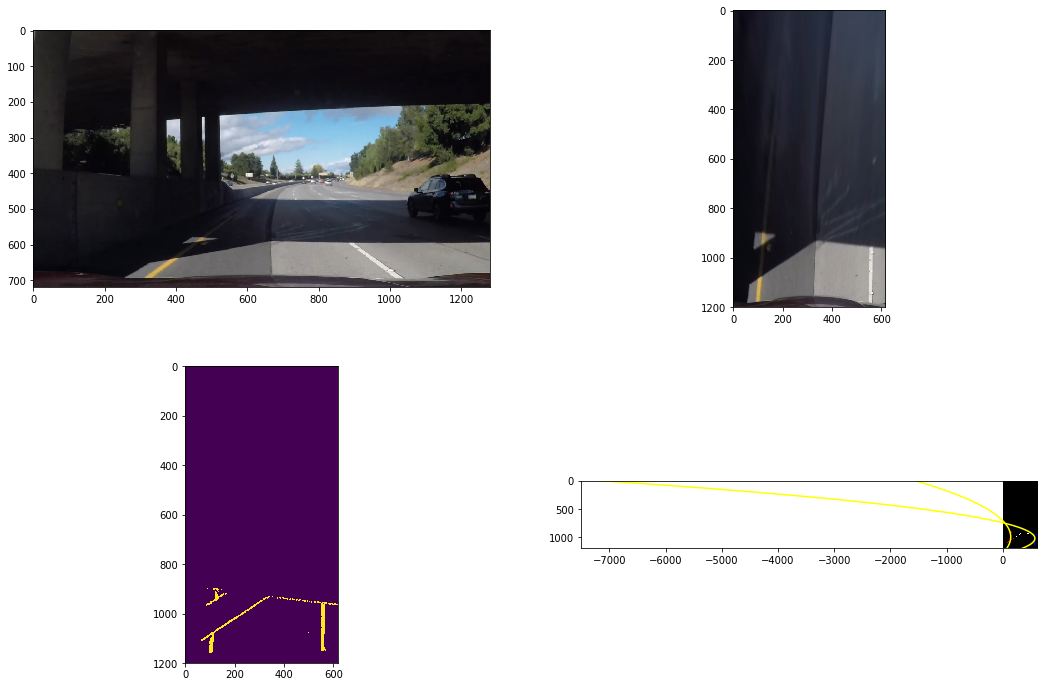

In [152]:
plot_diagnostics(4)

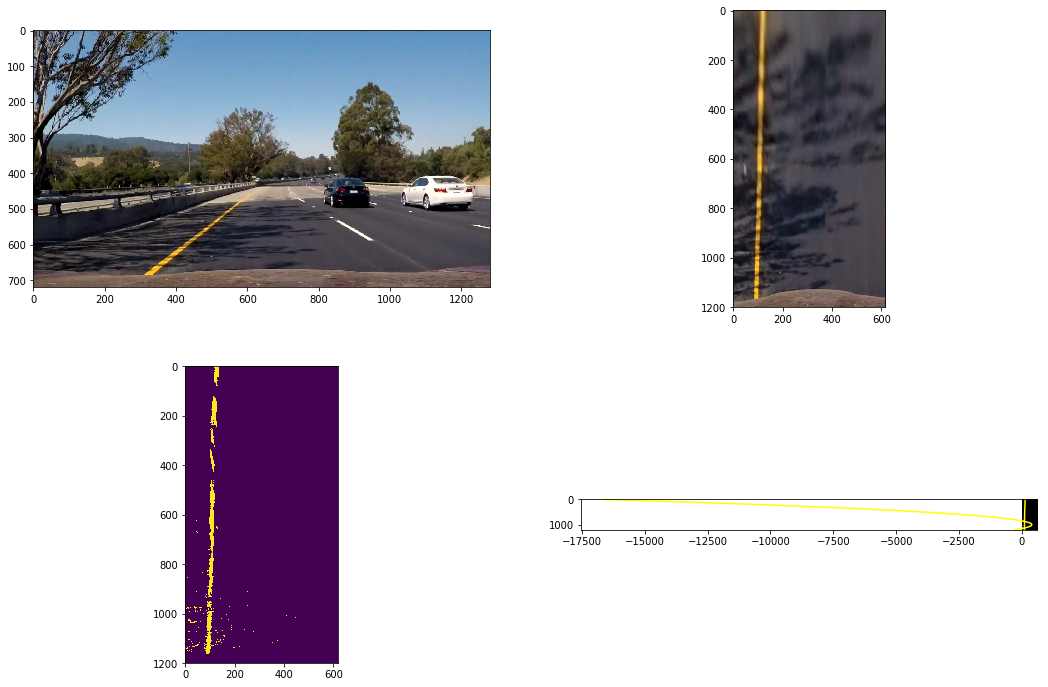

In [158]:
plot_diagnostics(5)